# Libraries

In [106]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

from scipy import stats


# FUNÇÕES DE AJUDA

# Identificar Var Numéricas e Categóricas

In [48]:
def get_feature_types(df, target_col='Tipo de Ataque'):
    '''
    Identifica Categorias Numéricas e Categóricas
    '''
    numeric_features = df.select_dtypes(include=[np.number]).columns.tolist()
    categorical_features = df.select_dtypes(exclude=[np.number]).columns.tolist()

    # Remove Variável Alvo
    if target_col in numeric_features:
        numeric_features.remove(target_col)
    if target_col in categorical_features:
        categorical_features.remove(target_col)

    return numeric_features, categorical_features

# Analizar Correlação Entre Features Numéricas

In [89]:
def correlation_analysis(df, numeric_features, threshold=0.85):
    '''
    Analiza Correlação entre Features Numéricas

    Threshold 0.85 para procurar correlações fortes
    '''

    corr_matrix = df[numeric_features].corr()

    plt.figure(figsize=(50, 50))
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0, linewidth= 0.5)

    plt.title('Correlação entre Features - Heatmap')
    plt.xticks(rotation=90)
    plt.yticks(rotation=0)
    plt.show()

    threshold = threshold
    high_corr = np.where(np.abs(corr_matrix) > threshold)
    high_corr = [(corr_matrix.index[x], corr_matrix.columns[y], corr_matrix.iloc[x, y]) for x, y in zip(*high_corr) if x != y and x < y]
    
    return high_corr


# Análise de Homogeneidade da Variância (Teste de Levene's)

In [50]:
def analyze_variance_homogen(df, numeric_features, target_col='Tipo de Ataque'):
    '''
    Análise de Variância Homogénea
    '''

    results_levene = {}

    for feature in numeric_features:
        groups = [group[feature].dropna().values for name, group in df.groupby(target_col) if not group[feature].dropna().empty] 

        groups = [group for group in groups if len(group) > 0 and np.any(group != 0) and np.var(group) > 0]

        if len(groups) < 2:
            print(f"Não existem grupos válidos para fazer o teste de Levene para a feature: {feature}")
            continue

        stat_levene, p_value_levene = stats.levene(*groups)  
        results_levene[feature] = {'Statistic': stat_levene, 'p-value': p_value_levene}  

    return results_levene



# Análise da Importância das Features com Teste Kurskal-Wallis

In [51]:
def analyze_feature_importance(df, numeric_features, target_col='Tipo de Ataque'):
    '''
    Análise de Importância de Features
    '''

    h_scores = {}

    for feature in numeric_features:
        groups = [group[feature].dropna().values for name, group in df.groupby(target_col)]
        h_stat, p_value = stats.kruskal(*groups)
        h_scores[feature] = {'H-Statistic': h_stat, 'p-value': p_value}

    h_scores_df = pd.DataFrame.from_dict(h_scores, orient='index')
    h_scores_df = h_scores_df.sort_values('H-Statistic', ascending=False)

    plt.figure(figsize=(18, 10))
    plt.bar(range(len(h_scores_df)), h_scores_df['H-Statistic'], color='skyblue')
    plt.xticks(range(len(h_scores_df)), h_scores_df.index, rotation=90)
    plt.title('Importância de Features - Teste de Kruskal-Wallis')
    plt.xlabel('Features')
    plt.ylabel('H-Statistic')
    plt.show()

    return h_scores_df

# Análise da Importância das Features com Random Forest

In [52]:
def analyze_feature_importance_rf(df, numeric_features, target_col='Tipo de Ataque'):
    '''
    Análise de Importância de Features com Random Forest
    '''

    hyper_params = {
        'n_estimators': 150, # Número de Árvores
        'max_depth': 5, # Limite da Profundidade das Árvores
        'random_state': 42, # Para Reprodutibilidade
        'n_jobs': -1 # Para Paralelização
    }

    X = df[numeric_features]
    y = df[target_col]

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=hyper_params['random_state'], stratify=y)

    rf = RandomForestClassifier(**hyper_params)

    rf.fit(X_train, y_train)

    cv_scores = cross_val_score(rf, X_train, y_train, cv=5, n_jobs=-1)
    print(f"Cross-Validation Scores: {np.mean(cv_scores):.4f} +/- {np.std(cv_scores):.4f}")

    y_pred = rf.predict(X_test)

    importances = rf.feature_importances_
    feature_importance_df = pd.DataFrame({'Feature': numeric_features, 'Importance': importances})
    feature_importance_df = feature_importance_df.sort_values('Importance', ascending=False)

    rf_labels = rf.classes_
    cm = confusion_matrix(y_test, y_pred)

    report = classification_report(y_test, y_pred, target_names=rf_labels)
    print("\nClassification Report:\n")
    print(report, end='\n\n')

    plt.figure(figsize=(18, 12))
    plt.bar(feature_importance_df['Feature'], feature_importance_df['Importance'], color='skyblue')
    plt.ylabel('Importância')
    plt.xlabel('Features')
    plt.title('Importância de Features - Random Forest')
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.show()

    return feature_importance_df, cm, rf_labels, cv_scores


# Cálculo da Percentagem de Outliers para Cada Feature com IQR

In [102]:
def calculate_outliers_percentage(df):
    """
    Cálculo da Percentagem de Outliers para cada Feature no DataFrame Utilizando o métod IQR
    """

    outlier_percentages = {}  

    for column in df.columns:
        Q1 = df[column].quantile(0.25)  
        Q3 = df[column].quantile(0.75)  
        IQR = Q3 - Q1 

        lower_bound = Q1 - 1.5 * IQR  
        upper_bound = Q3 + 1.5 * IQR  

        # Identificar Outliers nas Colunas
        outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)]

        # Percentagem de Outliers na Coluna
        outlier_percentage = len(outliers) / len(df) * 100
        
        outlier_percentages[column] = outlier_percentage

    return outlier_percentages

# 1. EXPLORAÇÃO INICIAL

# 1.1. Carregar o Ds

In [54]:
# Listar os DataFrames
dfs = []

# Carregar os DataFrames
for dirname, _, filenames in os.walk('./ds'):
    for filename in filenames:
        dfs.append(pd.read_csv(os.path.join(dirname, filename)))

In [55]:
# Dimensão dos Dados de Cada Ds Individual
for i, data in enumerate(dfs, start=1):
    rows, cols = data.shape
    print(f"Dataset {i}: {rows} linhas e {cols} colunas")

Dataset 1: 288602 linhas e 79 colunas
Dataset 2: 529918 linhas e 79 colunas
Dataset 3: 191033 linhas e 79 colunas
Dataset 4: 286467 linhas e 79 colunas
Dataset 5: 225745 linhas e 79 colunas
Dataset 6: 445909 linhas e 79 colunas
Dataset 7: 692703 linhas e 79 colunas
Dataset 8: 170366 linhas e 79 colunas


# 1.2. Junção dos Dataframes

In [56]:
# Concatenar os DataFrames
data = pd.concat(dfs, ignore_index=True)

# Apagar DataFrames depois de Concatenar
for df in dfs: del df

# 1.3. Overview dos Dados

In [57]:
# Apresentação das Primeiras Linhas do DS
data.head()

,Destination Port,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,...,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
0,22,166,1,1,0,0,0,0,0.0,0.0,...,32,0.000,0.000,0,0,0.0,0.000,0,0,BENIGN
1,60148,83,1,2,0,0,0,0,0.0,0.0,...,32,0.000,0.000,0,0,0.0,0.000,0,0,BENIGN
2,123,99947,1,1,48,48,48,48,48.0,0.0,...,40,0.000,0.000,0,0,0.0,0.000,0,0,BENIGN
3,123,37017,1,1,48,48,48,48,48.0,0.0,...,32,0.000,0.000,0,0,0.0,0.000,0,0,BENIGN
4,0,111161336,147,0,0,0,0,0,0.0,0.0,...,0,1753752.625,2123197.578,4822992,95,9463032.7,2657727.996,13600000,5700287,BENIGN


In [58]:
# Apresentação de 10 linhas aleatórias
data.sample(n=10, random_state=42)

,Destination Port,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,...,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
746827,53,30767,2,2,70,102,35,35,35.000000,0.000000,...,20,0.0000,0.00000,0,0,0.000,0.0000,0,0,BENIGN
946912,53,48461,2,2,76,200,38,38,38.000000,0.000000,...,20,0.0000,0.00000,0,0,0.000,0.0000,0,0,BENIGN
2216843,80,1,2,0,0,0,0,0,0.000000,0.000000,...,32,0.0000,0.00000,0,0,0.000,0.0000,0,0,DoS Hulk
699389,53,191,2,2,74,138,37,37,37.000000,0.000000,...,32,0.0000,0.00000,0,0,0.000,0.0000,0,0,BENIGN
1170268,2126,33,1,1,0,6,0,0,0.000000,0.000000,...,40,0.0000,0.00000,0,0,0.000,0.0000,0,0,PortScan
800686,44761,52,1,1,0,0,0,0,0.000000,0.000000,...,32,0.0000,0.00000,0,0,0.000,0.0000,0,0,BENIGN
1434488,31843,4000835,1,4,1375,18,1375,1375,1375.000000,0.000000,...,20,0.0000,0.00000,0,0,0.000,0.0000,0,0,BENIGN
1968368,443,60397661,13,12,984,3402,596,0,75.692308,168.374278,...,20,119347.1667,85254.73309,293371,84195,9946905.833,109697.6633,9993438,9723071,BENIGN
934343,443,263886,6,10,1091,4995,549,0,181.833333,226.009218,...,20,0.0000,0.00000,0,0,0.000,0.0000,0,0,BENIGN
693547,52676,36,1,1,6,6,6,6,6.000000,0.000000,...,20,0.0000,0.00000,0,0,0.000,0.0000,0,0,BENIGN


In [59]:
# Apresentar Dimensões do Ds
print(f"Dimensões do Dataset: {data.shape}")

Dimensões do Dataset: (2830743, 79)


In [60]:
# Apresentar Tipos de Dados
data.info()

# Podemos Verificar que o 'y' é a única variável categórica

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2830743 entries, 0 to 2830742
Data columns (total 79 columns):
 #   Column                        Dtype  
---  ------                        -----  
 0    Destination Port             int64  
 1    Flow Duration                int64  
 2    Total Fwd Packets            int64  
 3    Total Backward Packets       int64  
 4   Total Length of Fwd Packets   int64  
 5    Total Length of Bwd Packets  int64  
 6    Fwd Packet Length Max        int64  
 7    Fwd Packet Length Min        int64  
 8    Fwd Packet Length Mean       float64
 9    Fwd Packet Length Std        float64
 10  Bwd Packet Length Max         int64  
 11   Bwd Packet Length Min        int64  
 12   Bwd Packet Length Mean       float64
 13   Bwd Packet Length Std        float64
 14  Flow Bytes/s                  float64
 15   Flow Packets/s               float64
 16   Flow IAT Mean                float64
 17   Flow IAT Std                 float64
 18   Flow IAT Max         

In [61]:
# Procurar Valores Nulos
null_values = data.isna().sum()
null_percentage = (null_values / len(data)) * 100

# Apresentação de Colunas com Valores Nulos
for column, count in null_values.items():
    if count != 0:
        print(f"A Coluna {column}: tem {count} valores nulos, o que faz ({null_percentage[column]:.2f}% de valores em falta)")

A Coluna Flow Bytes/s: tem 1358 valores nulos, o que faz (0.05% de valores em falta)


# 2. Limpeza de Dados

In [62]:
#Remoção de Espaços em Branco
col_name = {col: col.strip() for col in data.columns}
data.rename(columns=col_name, inplace=True)

# 2.1. Dados Duplicados

In [63]:
# Verificar e Contar Duplicados
duplicates = data.duplicated()
duplicates_count = duplicates.sum()

print(f"Número de Linhas Duplicadas: {duplicates_count}")

Número de Linhas Duplicadas: 308381


In [64]:
# Remoção de Duplicados
data = data.drop_duplicates(keep='first')
del duplicates
data.shape

(2522362, 79)

In [65]:
# Colunas com Dados Duplicados
identical_columns = {}
columns = data.columns
list_contol = columns.copy().tolist()

# Comparação de cada par de colunas
for col1 in columns:    
    for col2 in columns:
        if col1 != col2:
            if data[col1].equals(data[col2]):
                if (col1 not in identical_columns) and (col1 in list_contol):
                    identical_columns[col1] = [col2]
                    list_contol.remove(col2)
                elif (col1 in identical_columns) and (col1 in list_contol):
                    identical_columns[col1].append(col2)
                    list_contol.remove(col2)

if identical_columns:
    print("Colunas Identicas Encontradas:")
    for key, value in identical_columns.items():
        print(f"{key}: é idêntico a {value}")
else: print("Não foram encontradas colunas idênticas")
                

Colunas Identicas Encontradas:
Total Fwd Packets: é idêntico a ['Subflow Fwd Packets']
Total Backward Packets: é idêntico a ['Subflow Bwd Packets']
Fwd PSH Flags: é idêntico a ['SYN Flag Count']
Bwd PSH Flags: é idêntico a ['Bwd URG Flags', 'Fwd Avg Bytes/Bulk', 'Fwd Avg Packets/Bulk', 'Fwd Avg Bulk Rate', 'Bwd Avg Bytes/Bulk', 'Bwd Avg Packets/Bulk', 'Bwd Avg Bulk Rate']
Fwd URG Flags: é idêntico a ['CWE Flag Count']
Fwd Header Length: é idêntico a ['Fwd Header Length.1']


In [66]:
# Remover Colunas com Valores Duplicados
for key, value in identical_columns.items():
    data.drop(columns=value, inplace=True)

In [67]:
print(data.columns)
data.shape

Index(['Destination Port', 'Flow Duration', 'Total Fwd Packets',
       'Total Backward Packets', 'Total Length of Fwd Packets',
       'Total Length of Bwd Packets', 'Fwd Packet Length Max',
       'Fwd Packet Length Min', 'Fwd Packet Length Mean',
       'Fwd Packet Length Std', 'Bwd Packet Length Max',
       'Bwd Packet Length Min', 'Bwd Packet Length Mean',
       'Bwd Packet Length Std', 'Flow Bytes/s', 'Flow Packets/s',
       'Flow IAT Mean', 'Flow IAT Std', 'Flow IAT Max', 'Flow IAT Min',
       'Fwd IAT Total', 'Fwd IAT Mean', 'Fwd IAT Std', 'Fwd IAT Max',
       'Fwd IAT Min', 'Bwd IAT Total', 'Bwd IAT Mean', 'Bwd IAT Std',
       'Bwd IAT Max', 'Bwd IAT Min', 'Fwd PSH Flags', 'Bwd PSH Flags',
       'Fwd URG Flags', 'Fwd Header Length', 'Bwd Header Length',
       'Fwd Packets/s', 'Bwd Packets/s', 'Min Packet Length',
       'Max Packet Length', 'Packet Length Mean', 'Packet Length Std',
       'Packet Length Variance', 'FIN Flag Count', 'RST Flag Count',
       'PSH Flag C

(2522362, 67)

In [68]:
# Verificar Valores Infinitos
num_columns = data.select_dtypes(include=np.number).columns
has_infinite = np.isinf(data[num_columns]).sum()
print(has_infinite[has_infinite > 0])

Flow Bytes/s      1211
Flow Packets/s    1564
dtype: int64


In [69]:
# Tratar Valores Infinitos
data.replace([np.inf, -np.inf], np.nan, inplace=True)

# 2.1. Valores em Falta

In [70]:
# Contagem de Ataques
attack_counts = data['Label'].value_counts().reset_index()
attack_counts.columns = ['Tipo de Ataque', 'Nº de Ocorrências']

# Duplicar o Ds e drop a linhas com valores nulos
data_no_na = data.dropna()

# Contar o nº de ocorrências total para cada ataque depois do drop
occurrences_nonull = data_no_na['Label'].value_counts().reset_index()
occurrences_nonull.columns = ['Tipo de Ataque', 'Nº de Ocorrências sem Valores Nulos']

# Juntar os Ds
attack_counts = attack_counts.merge(occurrences_nonull, on='Tipo de Ataque', how='left')

# Calcular a diferença
attack_counts['Diferença'] = attack_counts['Nº de Ocorrências'] - attack_counts['Nº de Ocorrências sem Valores Nulos']
attack_counts['Diferença em %'] = ((attack_counts['Diferença'] * 100) / attack_counts['Nº de Ocorrências']).round(2)

attack_counts

,Tipo de Ataque,Nº de Ocorrências,Nº de Ocorrências sem Valores Nulos,Diferença,Diferença em %
0,BENIGN,2096484,2095057,1427,0.07
1,DoS Hulk,172849,172846,3,0.00
2,DDoS,128016,128014,2,0.00
3,PortScan,90819,90694,125,0.14
4,DoS GoldenEye,10286,10286,0,0.00
5,FTP-Patator,5933,5931,2,0.03
6,DoS slowloris,5385,5385,0,0.00
7,DoS Slowhttptest,5228,5228,0,0.00
8,SSH-Patator,3219,3219,0,0.00
9,Bot,1953,1948,5,0.26


In [71]:
# Limpeza de Dados
del data_no_na

# Percentagem de Valores Nulos por Coluna
threshold = 10
missing_percentage = (data.isnull().sum() / len(data)) * 100

# Filtrar Colunas com Vaores Nulos acima do Threshold
high_missing_cols = missing_percentage[missing_percentage > threshold]

if len(high_missing_cols) > 0:
    print(f"Colunas com Valores Nulos acima de {threshold}%:")
    print(high_missing_cols)
else:
    print("Não existem colunas com valores nulos acima do threshold")

# O Ds aguenta remoção de linhas sem grande impacto

Não existem colunas com valores nulos acima do threshold


In [72]:
row_missing_percentage = (data.isna().sum(axis=1) / data.shape[1]) * 100
print(row_missing_percentage.describe())

missing_rows = data.isna().any(axis=1).sum()
print(f'\nTotal linhas com valores nulos: {missing_rows}')

count    2.522362e+06
mean     1.850907e-03
std      7.430795e-02
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      2.985075e+00
dtype: float64

Total linhas com valores nulos: 1564


In [73]:
# Drop aos Valores Nulos
data = data.dropna()
print(f'Dataset após remoção de valores nulos: {data.shape}')

Dataset após remoção de valores nulos: (2520798, 67)


# 2.2. Data-Driven Feature Selection

In [74]:
#Procura por colunas com um único valor, indicadoras de falta de diversidade
only_unique_cols = []
for col in data.columns:
    if len(data[col].unique()) == 1:
        only_unique_cols.append(col)
        print(col)

print(f'\nO nº de colunas com um único valor é: {len(only_unique_cols)}') 

# Colunas deste género podem ser removidas do Ds sem problemas

Bwd PSH Flags

O nº de colunas com um único valor é: 1


In [75]:
# Drop de Colunas com um Único Valor
data.drop(only_unique_cols, axis=1, inplace=True)
del only_unique_cols

In [76]:
data.shape

(2520798, 66)

# 2.3. Agrupar/Remover Tipos de Ataque

No Ds são categorizados vários tipos de ataque (como é o exemplo das diferentes distinções de DoS).
Dada a falta de equilíbrio no Ds, consolidar estes dados pode ajudar no treino dos Modelos.

# 2.3.1. Agrupar Ataques

In [77]:
# Organizar os Ataques por Grupos
group_mapping = {
    'BENIGN': 'Tráfego Normal',
    'DoS Hulk': 'DoS',
    'DDoS': 'DDoS',
    'DoS GoldenEye': 'DoS',
    'DoS slowloris': 'DoS',
    'DoS Slowhttptest': 'DoS',    
    'PortScan': 'Port Scanning',
    'FTP-Patator': 'Brute Force',
    'SSH-Patator': 'Brute Force',
    'Bot': 'Bots',
    'Web Attack Brute Force': 'Web Attack',
    'Web Attack XSS': 'Web Attack',
    'Web Attack Sql Injection': 'Web Attack',
    'Infiltration': 'Infiltração',    
    'Heartbleed': 'Variados'
}

# Mapear para um Novo Grupo
data['Tipos de Ataque'] = data['Label'].map(group_mapping)

In [78]:
data['Tipos de Ataque'].value_counts()

Tipos de Ataque
Tráfego Normal    2095057
DoS                193745
DDoS               128014
Port Scanning       90694
Brute Force          9150
Bots                 1948
Infiltração            36
Variados               11
Name: count, dtype: int64

In [79]:
# Drop à coluna 'Label'
data.drop(columns='Label', inplace=True)

# 2.3.2. Remoção de Tipos de Ataques

Vão ser removidos os ataques 'Inflitração' e 'Variados' pois, no futuro, podem ter consequências na fiabilidade do modelo.

In [80]:
# Remoção das linhas com Valores Irrelevantes
data.drop(data[(data['Tipos de Ataque'] == 'Infiltração') | (data['Tipos de Ataque'] == 'Variados')].index, inplace=True)

In [81]:
print(data.shape)
data['Tipos de Ataque'].value_counts()

(2520751, 66)


Tipos de Ataque
Tráfego Normal    2095057
DoS                193745
DDoS               128014
Port Scanning       90694
Brute Force          9150
Bots                 1948
Name: count, dtype: int64

# 3. EDA

# 3.1. Estatísticas

In [82]:
data.sample(10)

,Destination Port,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,...,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Tipos de Ataque
2423991,443,179525,7,5,376,3508,201,0,53.714286,78.686539,...,20,0.000,0.000,0,0,0.0,0.000000e+00,0,0,Tráfego Normal
967909,53,48461,1,1,78,160,78,78,78.000000,0.000000,...,32,0.000,0.000,0,0,0.0,0.000000e+00,0,0,Tráfego Normal
636471,53,215,2,2,88,188,44,44,44.000000,0.000000,...,32,0.000,0.000,0,0,0.0,0.000000e+00,0,0,Tráfego Normal
884334,443,102380224,25,20,2993,5303,615,0,119.720000,162.185470,...,20,1487288.333,2219548.829,4045859,78836,32200000.0,2.250000e+07,58200000,17600000,Tráfego Normal
1101739,2161,69,1,1,2,6,2,2,2.000000,0.000000,...,24,0.000,0.000,0,0,0.0,0.000000e+00,0,0,Port Scanning
1397803,80,1849899,3,3,26,11601,20,0,8.666667,10.263203,...,20,0.000,0.000,0,0,0.0,0.000000e+00,0,0,DDoS
1744800,80,111239334,24,18,2622,4776,437,0,109.250000,193.296404,...,32,917659.800,2827076.299,8963660,23524,10200000.0,3.929340e+04,10200000,10100000,Tráfego Normal
649686,53,58248,4,4,172,396,43,43,43.000000,0.000000,...,20,0.000,0.000,0,0,0.0,0.000000e+00,0,0,Tráfego Normal
1505256,53,187,2,2,84,116,42,42,42.000000,0.000000,...,32,0.000,0.000,0,0,0.0,0.000000e+00,0,0,Tráfego Normal
2218446,443,924300,5,6,2016,902,1442,0,403.200000,619.765843,...,20,0.000,0.000,0,0,0.0,0.000000e+00,0,0,Tráfego Normal


In [83]:
data.describe()

,Destination Port,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,...,act_data_pkt_fwd,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min
count,2.520751e+06,2.520751e+06,2.520751e+06,2.520751e+06,2.520751e+06,2.520751e+06,2.520751e+06,2.520751e+06,2.520751e+06,2.520751e+06,...,2.520751e+06,2.520751e+06,2.520751e+06,2.520751e+06,2.520751e+06,2.520751e+06,2.520751e+06,2.520751e+06,2.520751e+06,2.520751e+06
mean,8.690744e+03,1.659032e+07,1.025880e+01,1.155289e+01,6.065243e+02,1.811292e+04,2.311993e+02,1.920377e+01,6.350189e+01,7.732029e+01,...,5.997266e+00,-3.082291e+03,9.152230e+04,4.616835e+04,1.719410e+05,6.542438e+04,9.337159e+06,5.656738e+05,9.763454e+06,8.892545e+06
std,1.901294e+04,3.523140e+07,7.943824e+02,1.056905e+03,1.011595e+04,2.398149e+06,7.563122e+02,6.079887e+01,1.955512e+02,2.968824e+02,...,6.743909e+02,1.149769e+06,6.858746e+05,4.161453e+05,1.084664e+06,6.106447e+05,2.484810e+07,4.873871e+06,2.561725e+07,2.458139e+07
min,0.000000e+00,-1.300000e+01,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,-5.368707e+08,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,5.300000e+01,2.080000e+02,2.000000e+00,1.000000e+00,1.200000e+01,6.000000e+00,6.000000e+00,0.000000e+00,6.000000e+00,0.000000e+00,...,0.000000e+00,2.000000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,8.000000e+01,5.062000e+04,2.000000e+00,2.000000e+00,6.600000e+01,1.560000e+02,4.000000e+01,2.000000e+00,3.625000e+01,0.000000e+00,...,1.000000e+00,2.000000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
75%,4.430000e+02,5.332968e+06,6.000000e+00,5.000000e+00,3.320000e+02,9.970000e+02,2.020000e+02,3.700000e+01,5.200000e+01,7.419280e+01,...,3.000000e+00,3.200000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
max,6.553500e+04,1.200000e+08,2.197590e+05,2.919220e+05,1.290000e+07,6.554530e+08,2.482000e+04,2.325000e+03,5.940857e+03,7.125597e+03,...,2.135570e+05,1.380000e+02,1.100000e+08,7.420000e+07,1.100000e+08,1.100000e+08,1.200000e+08,7.690000e+07,1.200000e+08,1.200000e+08


# 3.2. Análise de Correlação

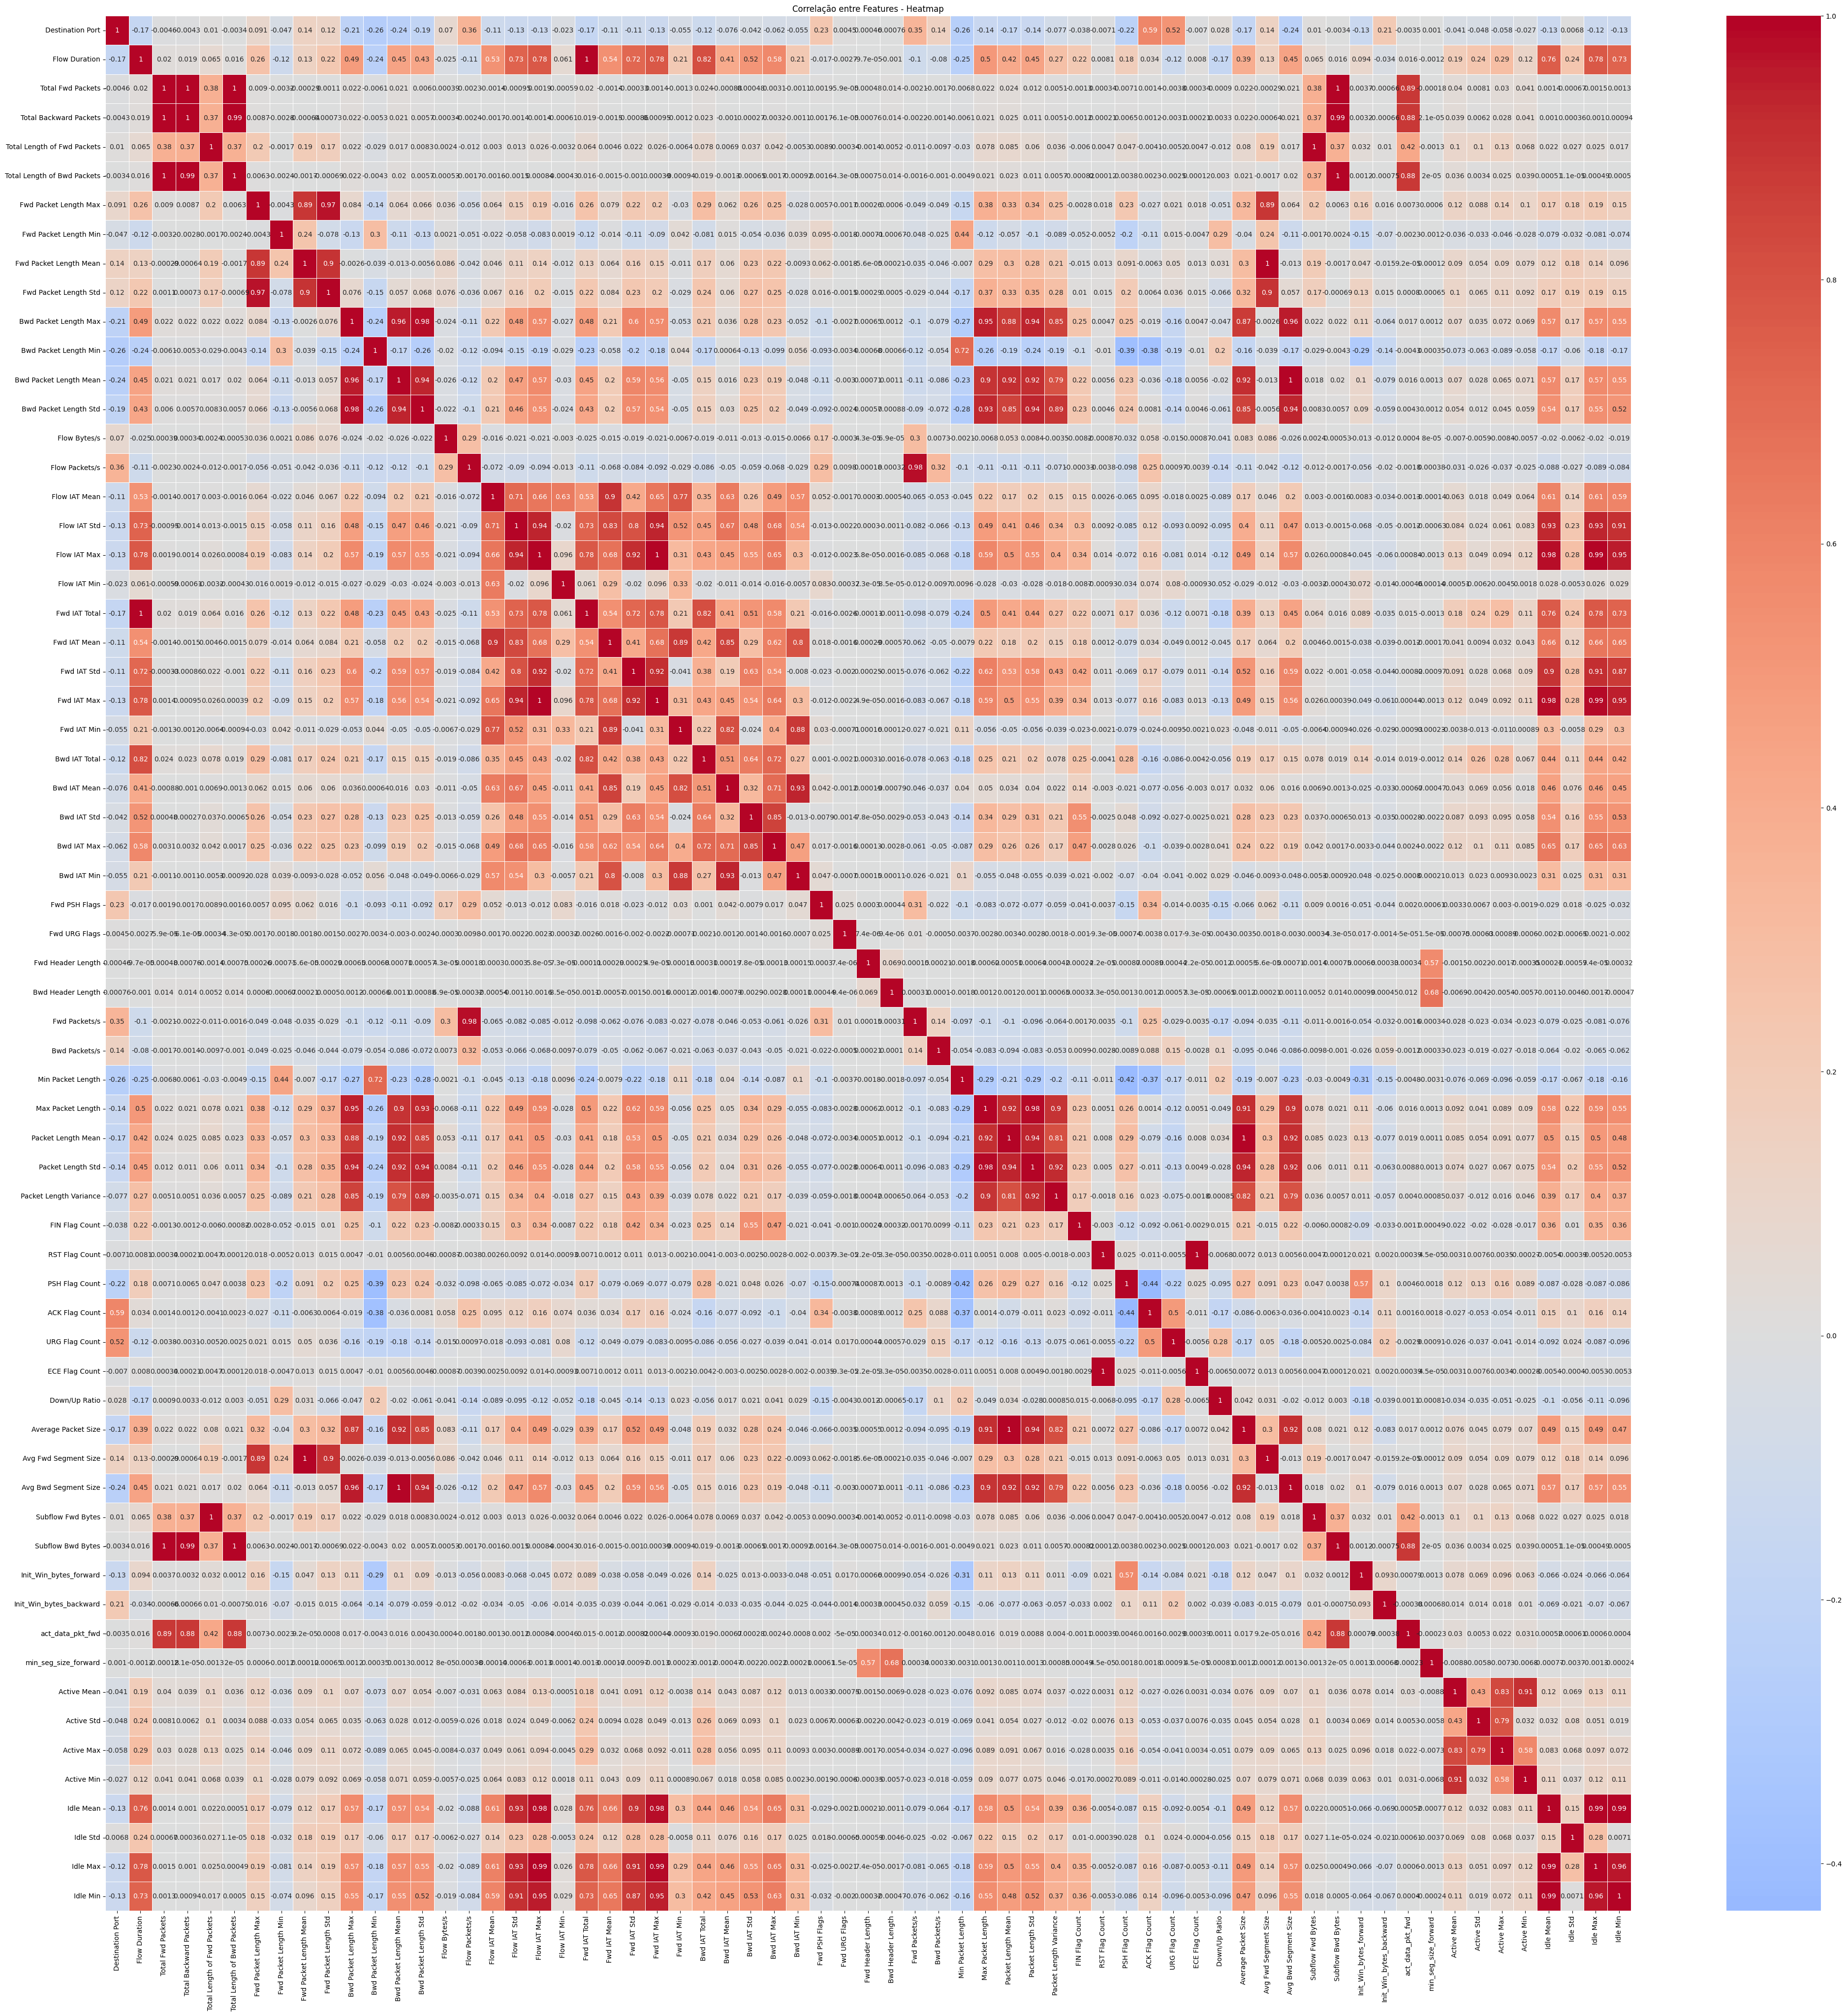

In [90]:
# Análise de Correlação
numeric_features, categorical_features = get_feature_types(data)
high_corr = correlation_analysis(data, numeric_features)

In [91]:
# Apresentação dos Pares com Alta Correlação e Eliminação dos Pares com próxima Multiconinearidade
high_multicollinearity = []
for item in high_corr:
    print(f'{item[0]} tem Correlação Elevada com {item[1]}: {item[2].round(4)}')
    if item[2] >= 0.95:
        high_multicollinearity.append(item)

Flow Duration tem Correlação Elevada com Fwd IAT Total: 0.9985
Total Fwd Packets tem Correlação Elevada com Total Backward Packets: 0.9991
Total Fwd Packets tem Correlação Elevada com Total Length of Bwd Packets: 0.997
Total Fwd Packets tem Correlação Elevada com Subflow Bwd Bytes: 0.997
Total Fwd Packets tem Correlação Elevada com act_data_pkt_fwd: 0.8874
Total Backward Packets tem Correlação Elevada com Total Length of Bwd Packets: 0.9945
Total Backward Packets tem Correlação Elevada com Subflow Bwd Bytes: 0.9944
Total Backward Packets tem Correlação Elevada com act_data_pkt_fwd: 0.8826
Total Length of Fwd Packets tem Correlação Elevada com Subflow Fwd Bytes: 1.0
Total Length of Bwd Packets tem Correlação Elevada com Subflow Bwd Bytes: 1.0
Total Length of Bwd Packets tem Correlação Elevada com act_data_pkt_fwd: 0.884
Fwd Packet Length Max tem Correlação Elevada com Fwd Packet Length Mean: 0.889
Fwd Packet Length Max tem Correlação Elevada com Fwd Packet Length Std: 0.9686
Fwd Packet 

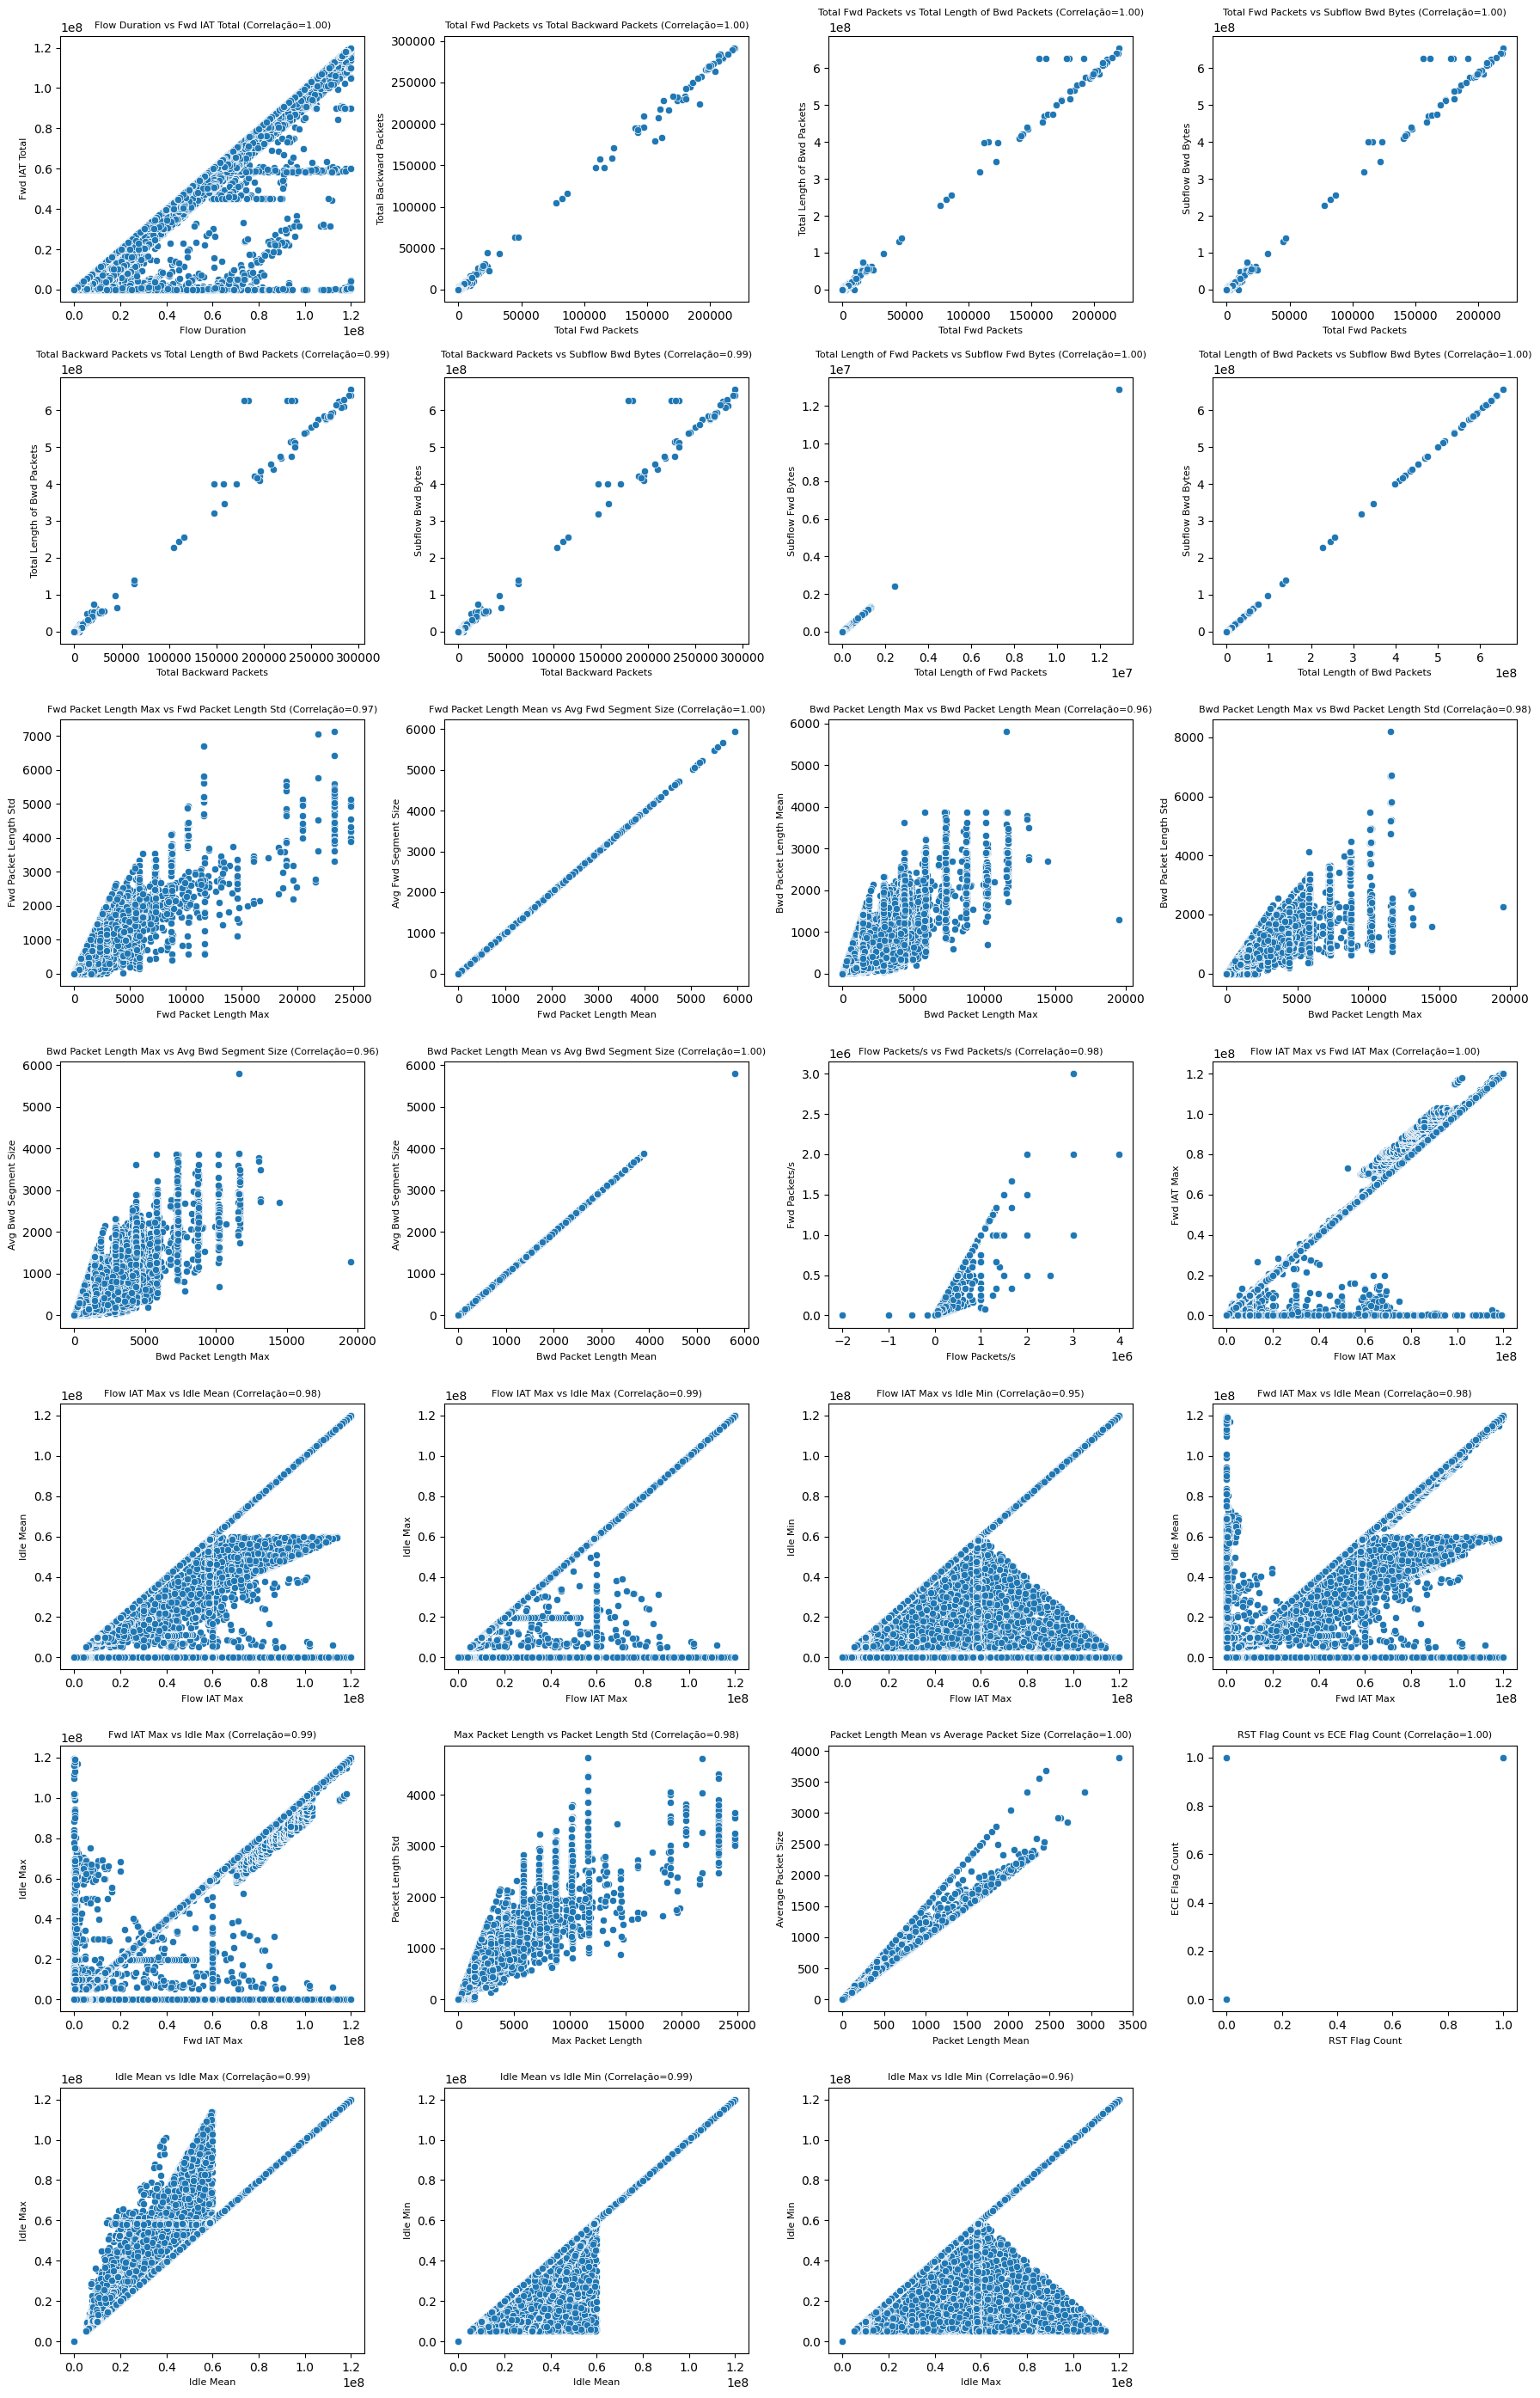

In [92]:
# Apresentação Gráfica com Elevada Correlação
n_plots = len(high_multicollinearity)
n_cols = 4
n_rows = (n_plots + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, n_rows * 4))
axes = axes.flatten()

for i, item in enumerate(high_multicollinearity):
    feature_x = item[0]
    feature_y = item[1]
    corr_value = item[2]

    sns.scatterplot(x=data[feature_x], y=data[feature_y], ax=axes[i])
    axes[i].set_title(f'{feature_x} vs {feature_y} (Correlação={corr_value:.2f})', fontsize=8)
    axes[i].set_xlabel(feature_x, fontsize=8)
    axes[i].set_ylabel(feature_y, fontsize=8)

# Esconder Gráficos Não Utilizados
for j in range(len(high_multicollinearity), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

In [93]:
# Remoção de Colunas Baseadas no Estudo da Alta Correlação
selected_columns = ['Total Backward Packets', 'Total Length of Bwd Packets', 'Subflow Bwd Bytes', 'Avg Fwd Segment Size', 'Avg Fwd Segment Size', 'Avg Bwd Segment Size']

data.drop(columns=selected_columns, inplace=True)

In [94]:
numeric_features, categorical_features = get_feature_types(data)
data.shape

(2520751, 61)

# 3.3. Outliers

<Figure size 1500x1000 with 0 Axes>

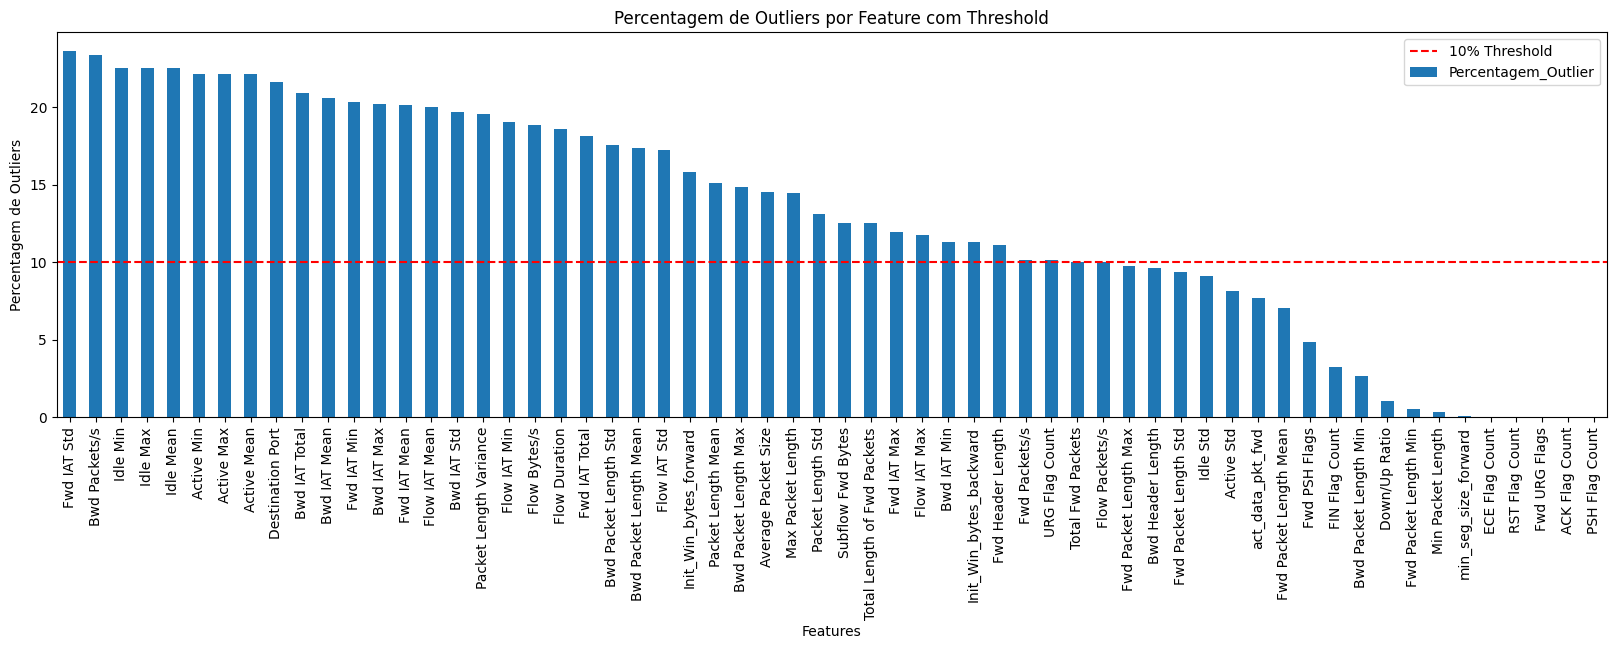

In [103]:
# Calculate outliers percentage
outlier_percentages = calculate_outliers_percentage(data[numeric_features])

# Convert to DataFrame for easier manipulation
outliers_df = pd.DataFrame.from_dict(outlier_percentages, orient='index', columns=['Percentagem_Outlier'])

# Define the threshold for concern
threshold = 10

# Identify features with high percentage of outliers
high_outlier_features = outliers_df[outliers_df['Percentagem_Outlier'] > threshold]

# Plot the outlier percentages and highlight features above the threshold
plt.figure(figsize=(15, 10))
outliers_df.sort_values(by='Percentagem_Outlier', ascending=False).plot(kind='bar', legend=False, figsize=(20, 5))
plt.axhline(y=threshold, color='r', linestyle='--', label=f'{threshold}% Threshold')
plt.xlabel('Features')
plt.ylabel('Percentagem de Outliers')
plt.title('Percentagem de Outliers por Feature com Threshold') 
plt.legend()
plt.show()

In [104]:
# Apresentar Features com Maior Percentagem de Outliers
print(f"Features com Percentagem de Outliers acima de {threshold}%:\n")
print(high_outlier_features.sort_values('Percentagem_Outlier', ascending=False))

del outliers_df

Features com Percentagem de Outliers acima de 10%:

                             Percentagem_Outlier
Fwd IAT Std                            23.657989
Bwd Packets/s                          23.402391
Idle Min                               22.501508
Idle Max                               22.501508
Idle Mean                              22.501508
Active Min                             22.167917
Active Max                             22.167917
Active Mean                            22.167917
Destination Port                       21.645137
Bwd IAT Total                          20.926819
Bwd IAT Mean                           20.602908
Fwd IAT Min                            20.366311
Bwd IAT Max                            20.187555
Fwd IAT Mean                           20.126462
Flow IAT Mean                          19.985512
Bwd IAT Std                            19.700319
Packet Length Variance                 19.538899
Flow IAT Min                           19.072649
Flow Bytes/s     

# 3.4. Distribuição dos Dados

Entnder a Distribuição Ajuda na Seleção do Modelo

In [108]:
norm_dist = 0
not_norm_dist = 0

for col in numeric_features:
    # Teste de Anderson-Darling
    result = stats.anderson(data[col], dist='norm')

    # Comparação da Estatística com o valor crítico a 5% de significância
    if result.statistic < result.critical_values[2]:
        norm_dist += 1
    else:
        not_norm_dist += 1

print(f'{norm_dist} features são distribuídas normalmente')
print(f'{not_norm_dist} features não são distribuídas normalmente')

0 features são distribuídas normalmente
60 features não são distribuídas normalmente


# 3.5. Não Balanceamento das Classes

In [115]:
# Contagem das Ocorrências para Cada Ataque e Conversão para DataFrame
attack_counts_df = data['Tipos de Ataque'].value_counts().reset_index()
attack_counts_df.columns = ['Tipos de Ataque', 'Nº de Ocorrências']

# Contagem do Total para cada Ataque em Ambos os Casos
total_occurrences = attack_counts_df['Nº de Ocorrências'].sum()

attack_counts_df['% do Total'] = ((attack_counts_df['Nº de Ocorrências'] / total_occurrences) * 100).round(2)

print(attack_counts_df)

  Tipos de Ataque  Nº de Ocorrências  % do Total
0  Tráfego Normal            2095057       83.18
1             DoS             193745        7.69
2            DDoS             128014        5.08
3   Port Scanning              90694        3.60
4     Brute Force               9150        0.36
5            Bots               1948        0.08


A análise anterior apresenta uma clara falta de equilíbrio:
- Dominânica da classe 'BENIGN' - 83,1%
- Mesmo DoS sendo a 2ª classe mais relevante, tem muito poucas contagens
- Mesmo após o agrupamento, classes como 'Bots', 'Web Attacks' e 'Brute Force' são muito poucas

Implicações Possíveis
- Pode levar a um modelo 'biased' - com elevada Accuracy mas pouco recall e precisão, para classes mais pequenas
- Métricas de Perfromance - Devem ser bem escolhidas

Ideias para Problemas no Treino do Modelo
- Classes de Peso para penalizar erros nas classes minoritárias
- Métodos como Random Forest podem melhorar as Previsões
- Cross-Validation com folds representativas
- Diminuir as samples da classe maioritaria

In [116]:
del attack_counts_df